In [1]:
# ---- Imports ----
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pennylane as qml
import torch
from tqdm import tqdm
#import kagglehub

In [2]:
# ---- Load Data ----
#path=kagglehub.dataset_download("siddharthss/crop-recommendation-dataset")
#data = os.path.join(path, "Crop_recommendation.csv")
df = pd.read_csv("Crop_recommendation.csv")

In [3]:
# Features & labels
X = df[['N','P','K','temperature','humidity','ph','rainfall']]
le = LabelEncoder()
y = le.fit_transform(df['label'])

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
# ---- Scale Features (important for quantum encoding) ----
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# ---- Convert to Torch tensors ----
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [7]:
# ---- Quantum Device ----
n_qubits = X_train_t.shape[1]  # one qubit per feature
dev = qml.device("default.qubit", wires=n_qubits)


In [8]:
# ---- Quantum Feature Map (AngleEmbedding + entanglement) ----
def feature_map(x):
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)
        qml.RY(x[i], wires=i)
    # add CZ entangling layer
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])

In [9]:
# ---- QNode for feature extraction ----
@qml.qnode(dev, interface="torch")
def qnode(x):
    feature_map(x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


In [10]:
def quantum_features(X):
    features = []
    for i in tqdm(range(len(X)), desc="Computing Quantum Features"):
        x_tensor = torch.tensor(X[i], dtype=torch.float32)
        q_out = torch.tensor(qnode(x_tensor), dtype=torch.float32)  # convert list -> tensor
        features.append(q_out)
    return torch.stack(features).cpu().numpy()


In [11]:
# ---- Compute Features ----
X_train_q = quantum_features(X_train_scaled)
X_test_q = quantum_features(X_test_scaled)


Computing Quantum Features: 100%|████████████████████████████████████████████████████| 440/440 [00:16<00:00, 27.23it/s]


In [12]:
# ---- Train Classical SVM on Quantum Features ----
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_q, y_train)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [13]:
# ---- Evaluate ----
y_train_pred = svm_model.predict(X_train_q)
y_test_pred = svm_model.predict(X_test_q)


test_acc = accuracy_score(y_test, y_test_pred)


print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.9590909090909091


In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# ---- Evaluation ----
conf_matrix_rbf = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix_rbf)
print("\n")

print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Confusion Matrix:
[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 19  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0

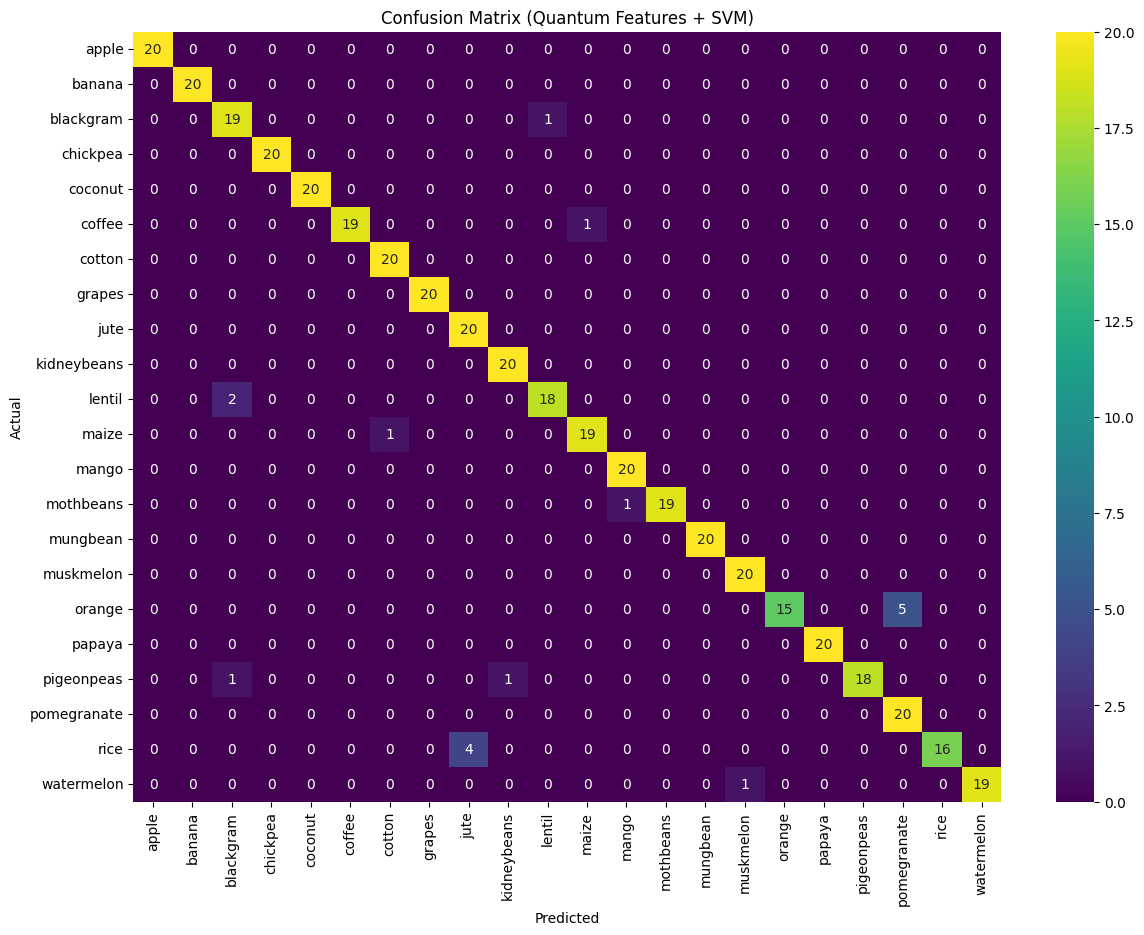

'\n# -----------------------------\n# 3️⃣ Classification Report\n# -----------------------------\nreport = classification_report(y_test, y_test_pred, target_names=le.classes_)\nprint("Classification Report:\n")\nprint(report)\n\n# -----------------------------\n# 4️⃣ Optional: Visualize Accuracy per Class\n# -----------------------------\nclass_acc = cm.diagonal() / cm.sum(axis=1)\nplt.figure(figsize=(12,5))\nsns.barplot(x=le.classes_, y=class_acc)\nplt.xticks(rotation=45)\nplt.ylabel("Accuracy")\nplt.title("Per-Class Accuracy (Quantum Features + SVM)")\nplt.show()\n'

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
"""
# -----------------------------
# 1️⃣ Accuracy
# -----------------------------
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
"""

# -----------------------------
# 2️⃣ Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(14,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Quantum Features + SVM)")
plt.show()

"""
# -----------------------------
# 3️⃣ Classification Report
# -----------------------------
report = classification_report(y_test, y_test_pred, target_names=le.classes_)
print("Classification Report:\n")
print(report)

# -----------------------------
# 4️⃣ Optional: Visualize Accuracy per Class
# -----------------------------
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12,5))
sns.barplot(x=le.classes_, y=class_acc)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy (Quantum Features + SVM)")
plt.show()
"""

In [44]:
# ---- Predict on New Sample ----
sample = np.array([[90, 40, 40, 25, 70, 6.5, 200]], dtype=np.float32)
sample_scaled = scaler.transform(sample)
sample_q = quantum_features(sample_scaled)
pred_encoded = svm_model.predict(sample_q)
pred_crop = LabelEncoder().fit(df['label']).inverse_transform(pred_encoded.astype(int))
print("Recommended Crop:", pred_crop[0])

C:\Users\91877\miniconda3\envs\quanenv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
Computing Quantum Features: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]

Recommended Crop: maize


In [ ]:
import pickle

# Save the trained model
with open("svm_crop_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

print("✅ Model saved as svm_crop_model.pkl")


In [ ]:
import joblib

# Save
joblib.dump((svm_model, le), "svm_crop_pipeline.pkl")

# Load
model, le = joblib.load("svm_crop_pipeline.pkl")